# DATA5710 - Applied Statistics for Complex Data

## Tutorial 5 - Dimension Reduction (Shrinkage, Variable selection, feature extraction)

## **Semester 1, 14 April 2022**

**Objectives:**

* Limitation of ML estimators and regularization  
* Bayesian shrinkage prior in regression
* Curse of dimensionality.

* Exercises to be completed on IPython notebook such as: 
   * Ipython 3 (Jupyter) notebook installed on your computer http://jupyter.org/install (you need to have Python installed first https://docs.python.org/3/using/index.html )
   * Web-based Ipython notebooks such as Google Colaboratory https://colab.research.google.com/ 
   
* If you are using Jupyter intalled on your computer, Go to File->Open. Drag and drop the ".ipynb" file to the home interface and click upload. 
* If you are using Google Colaboratory, Click File->Upload notebook, and and upload the ".ipynb" file
* Complete exercises in the ".ipynb".
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.
* Complete all exercises marked with **TODO**.
* Save your file when you are done with the exercises, so you can show your tutor next week.

* Useful resources:
    https://docs.pymc.io/notebooks/getting_started.html#:~:text=PyMC3


Lecturers: Lachlan Astfalck (content from Gilad Francis and Sally Cripps)

 ------------------------------------------------------------------------------------------------------------------

# **Bayesian Regression - Priors and Shrinkage**

## Likelihood function:
**modelling the residual from a linear regression**

$$
\mathbf{y} \sim   \mathcal{N}(X\mathbf{w}, \sigma)
$$


**Finding the posterior of the weights using Bayes' rule:**

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y}| X, \mathbf{w}) p(\mathbf{w})
$$

**Assumptions:**

**1. iid (given weights):**

$$
p(\mathbf{y} | X, \mathbf{w}) =  \prod_j p(y_j | \mathbf{x}_j, \mathbf{w}) 
$$

**2. Residuals at each data point are normally distributed:**

$$
-\log p(\mathbf{y} | X, \mathbf{w}) =  \frac{1}{2\sigma^2} \sum_j (\mathbf{x}_j \cdot \mathbf{w} - y_j)^2  + const
$$


**Inference - find posterior of w:**

$$
-\log p(\mathbf{w} | X, \mathbf{y}) \propto - \sum_j \log p(y_j | \mathbf{x}_j, \mathbf{w})  - \log p(\mathbf{w})
$$

## **Inference**
Inference of the linear model coeffcients can be done in closed form for a limited set of likelihood functions and prior. 

**In all other case, posterior has to be either approximated or sampled.**


Lets start with building a sampling scheme for a posterior using pymc3:

1. **pipeline** - standartize data (why????) + create features
2. **PyMC3 model** - general model (fit, predict, plot)
3. **Model specification** - linear, etc.


In [2]:
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import pymc3 as pm
import theano.tensor as tt
import arviz

import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [3]:
#Synthetic data
n_sample=10
np.random.seed(80)
x = np.random.rand(1,n_sample)*10.-5.
y = 1-3*x+0.3*x**2 + 0.2*x**3
y += 0.5*np.random.randn(*y.shape)
x= np.transpose(x)
y= np.transpose(y)

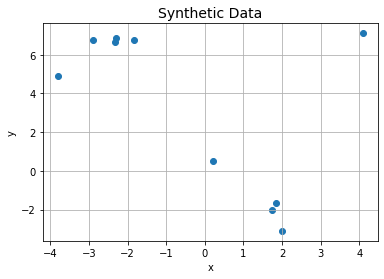

In [4]:
#scatter plot of y vs. x
plt.scatter(x, y)
plt.title('Synthetic Data', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [5]:
#Create a pipeline -> standardize data and create polynomial features

def gen_polynomial(x_original, degree=4):
    """Takes a vector and generates polynomial features for it."""
    pipe = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(with_mean=False)
                         ) 
    pipe.fit(x_original)

    return pipe.transform, pipe.named_steps['standardscaler'].scale_


In [6]:
transform, scale = gen_polynomial(x, degree=6)
x_p = transform(x)

print("degree of x_p is {}".format(x_p.shape))
print("mean of x_p elements: {}".format(x_p.mean(axis=0)))
print("std of x_p elements: {}".format(x_p.std(axis=0)))
print("scale: {}".format(scale))

degree of x_p is (10, 7)
mean of x_p elements: [ 1.         -0.12937678  1.27659235 -0.07487158  0.72145658  0.01391784
  0.56900117]
std of x_p elements: [0. 1. 1. 1. 1. 1. 1.]
scale: [1.00000000e+00 2.50724774e+00 5.00669881e+00 2.93377480e+01
 9.13685981e+01 4.41621481e+02 1.52113632e+03]


In [7]:
class PyMC3Model(object):
    #Wrapper around pymc3 models
    def __init__(self, model: pm.Model, transform=lambda j: j):
        self.model = model #observations are already embedded in model
        self.trace_ = None
        self.transform = transform
        self.prior_samples = None

    
    def fit(self, X=None, y=None, n_samples=500, n_prior_samples=100,step_str='NUTS',**kwargs):
               
        with self.model:
            if X is not None:
                pm.set_data({'features': self.transform(X)})
            if y is not None:
                pm.set_data({'observed': np.squeeze(y)})
            
            #sample prior
            try:
                self.prior_samples = pm.sample_prior_predictive(samples=n_samples)
            except ValueError as e:
                prior_checks = None
                print("Cannot sample prior")
                print(e)
            #sample posterior
            
            if step_str == 'NUTS':
                step = pm.NUTS()
            elif step_str == 'Metropolis':
                step = pm.Metropolis()
            else:
                print(f'Unsupported sampler {step} - Using NUTS')
                step = pm.NUTS()
            
            self.trace_ = pm.sample(n_samples,step=step,**kwargs)
    
    def predict_y(self, X, n_samples=100, pm_sample=False):
        #Predictive samples of y
        if self.trace_ is None:
            return None
        
        with self.model:
            if pm_sample:
                pm.set_data({'features': self.transform(X)})
                y_samples = pm.sample_posterior_predictive(self.trace_, var_names=["w", "y"], samples=n_samples)
            else:
                x_aug = self.transform(X)
                y_samples = self.trace_['w'].dot(x_aug.T)

        return y_samples
    
    
    def predict_prior(self, X, n_samples=100, resample=False, **kwargs):
        
        if resample:
            with self.model:
                pm.set_data({'features': self.transform(X)}) 
                self.prior_samples = pm.sample_prior_predictive(samples=n_samples, **kwargs)

        return self.prior_samples #None if not sampled
                       
    def plot_trace(self, combined=True):
        
        if self.trace_ is not None:
            arviz.plot_trace(linear_model.trace_, combined=True)
            
        
    def plot(self, x, y, plot_prior=False, n_samples=500):
        line_kwargs = {'color': 'blue'}
        line_kwargs['linewidth'] = 1
        line_kwargs['alpha'] = 0.3
        dot_kwargs = {'alpha': 0.3}
        plt.figure(figsize=(16, 8))
        
        x_inp = np.atleast_2d(np.linspace(x.min(), x.max(), num=500)).T 
        
        if plot_prior:
            
            prior_samples = self.predict_prior(x_inp, n_samples=n_samples,resample=True)
            w_prior = prior_samples['w']
            x_aug = self.transform(x_inp)
            y_fit = w_prior.dot(x_aug.T)
            
        elif self.trace_ is not None:
            #Samples exist
            
            post_samples = self.predict_y(x_inp, n_samples=n_samples)
            try:
                #Sample from pymc3 - with measurement noise
                y_fit = post_samples['y']
            except IndexError:
                #Linear fit using samples wights
                y_fit = post_samples
            
        else:
            return #do nothing
        
        y_mean = y_fit.mean(axis=0)
        y_std = y_fit.std(axis=0)
        #limit number of samples to plot - randomlly choose 100 smaples
        y_fit = y_fit[np.unique(np.random.randint(0, high=y_fit.shape[0], size=10)),:]

        x_plt = np.repeat(x_inp.T, y_fit.shape[0], axis=0)
        plt.plot(x_plt.T, y_fit.T, '-', **line_kwargs)
        
        plt.plot(np.squeeze(x_inp), y_mean, label='Prediction Mean', color='g')
        if not plot_prior:
            plt.fill_between(np.squeeze(x_inp), y_mean - 3*y_std, y_mean + 3*y_std, color='g',alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')

        plt.plot(x, y, 'ro', **dot_kwargs,label='Data')
        plt.legend(loc='upper left')
        

In [8]:
def linear_regression(X, y, degree=2):
    transform, scale = gen_polynomial(x, degree=degree)
    x_p = transform(x)

    with pm.Model() as model:
        w = pm.Flat('w', shape=x_p.shape[1]) #This is not really a prior!!
        σ = pm.HalfCauchy('σ', beta=20.)
        x_ = pm.Data('features', x_p)
        y_ = pm.Data('observed', y.squeeze())
        y_obs = pm.Normal('y', mu=tt.dot(x_, w), sd=σ, observed=y_)

    return model, transform


In [9]:
# Define linear model:
model, transform = linear_regression(x, y, degree=3)
linear_model = PyMC3Model(model, transform=transform)

In [10]:
#inference
linear_model.fit(x,y ,n_samples=10000,tune=10000,step_str='NUTS')

Cannot sample prior
Cannot sample from Flat distribution


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 44 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6239525160692109, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6953823912999273, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

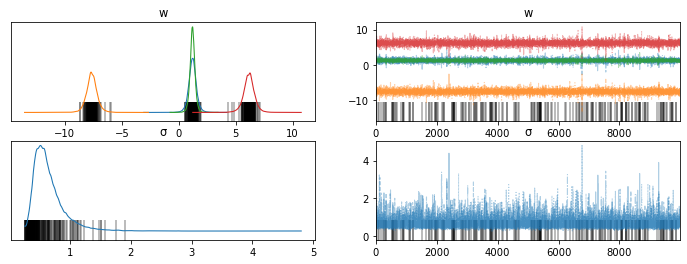

In [12]:
arviz.plot_trace(linear_model.trace_, combined=True)

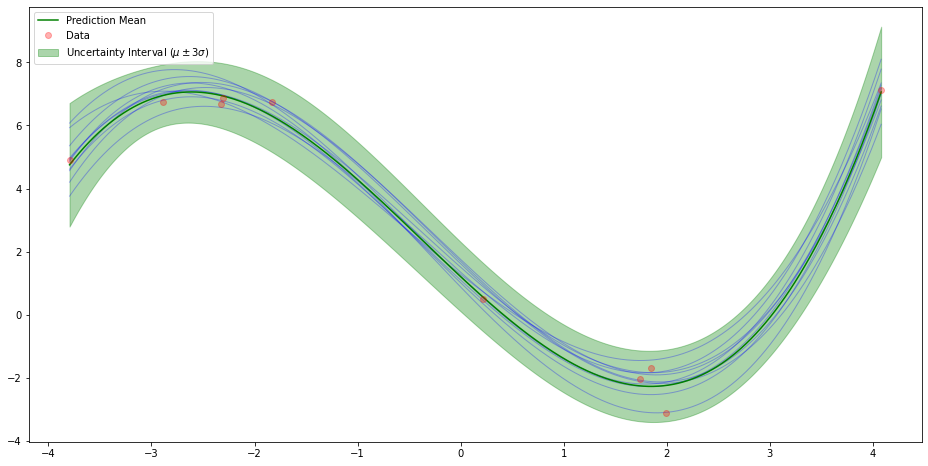

In [13]:
linear_model.plot(x,y)

Text(0.5, 1.0, 'Cubic - Flat prior')

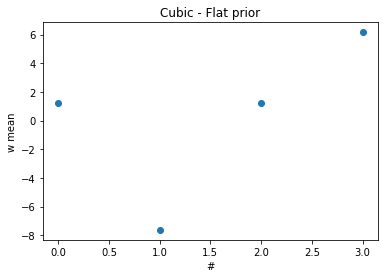

In [14]:
w = linear_model.trace_['w']
w = w.mean(axis=0)

plt.scatter(np.arange(w.size), w.flatten());
plt.xlabel('#')
plt.ylabel('w mean')
plt.title('Cubic - Flat prior')

Cannot sample prior
Cannot sample from Flat distribution


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

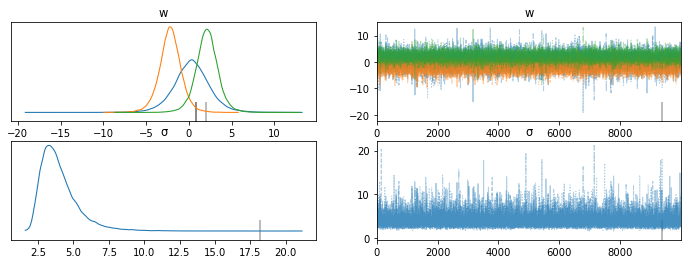

In [17]:
#TODO: Quadratic Fit -  Exaplain the graphs
# Define linear model:
model, transform = linear_regression(x, y, degree=2)
linear_model = PyMC3Model(model, transform=transform)

#inference
linear_model.fit(x,y ,n_samples=10000,tune=10000,step_str='NUTS')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

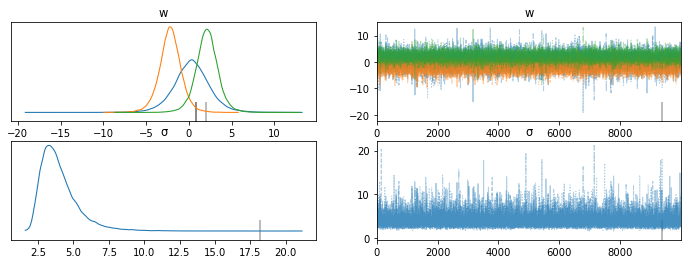

In [19]:
arviz.plot_trace(linear_model.trace_, combined=True)

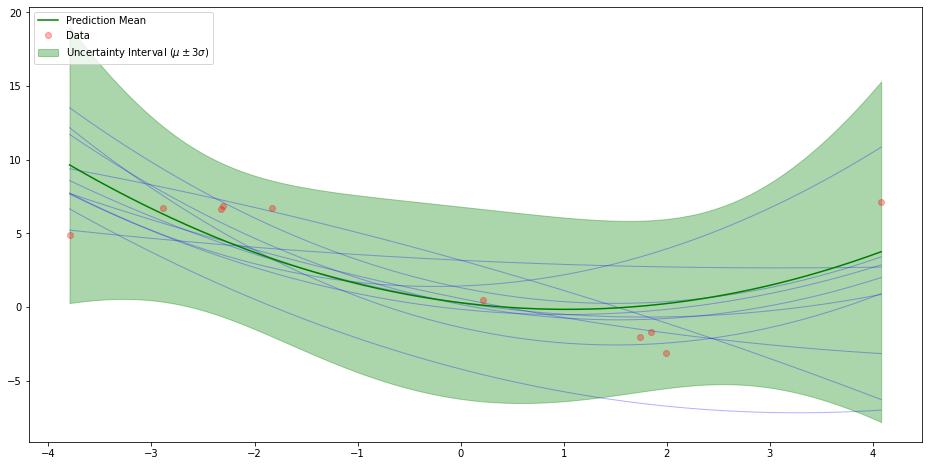

In [20]:
linear_model.plot(x,y)

In [21]:
#TODO: sextic (d=6) Fit -  Exaplain the graphs, how is it different to quadratic and cubic fits)?
model, transform = linear_regression(x, y, degree=6)

linear_model = PyMC3Model(model, transform=transform)

#inference
linear_model.fit(x,y ,n_samples=10000,tune=10000,step_str='NUTS')

Cannot sample prior
Cannot sample from Flat distribution


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 334 seconds.
There were 4575 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45606467640202264, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27373285606941783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4909 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35972795027835425, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3289 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6528654654856433, but shou

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

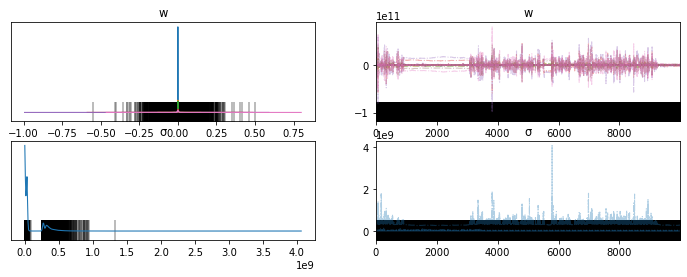

In [22]:
arviz.plot_trace(linear_model.trace_, combined=True)

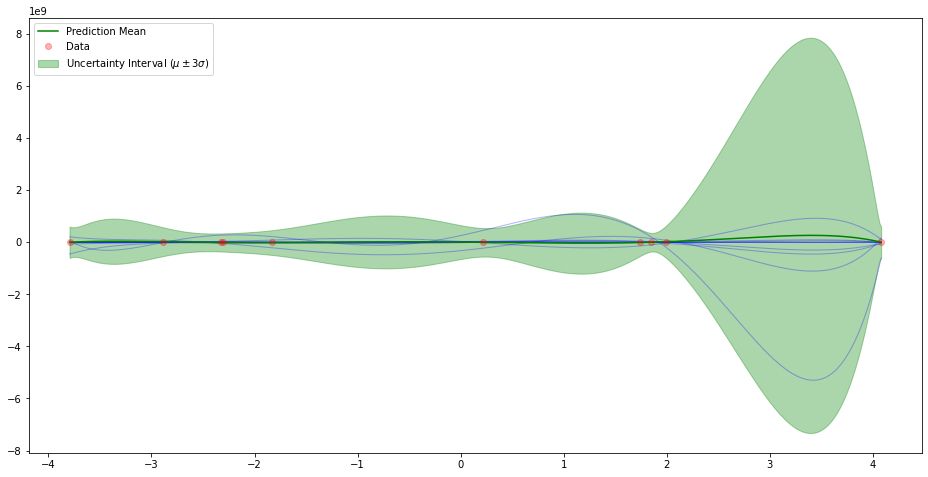

In [23]:
linear_model.plot(x,y)

In [25]:
#TODO - What happems if noise is 0? Re-compute data without noise -> fit it to a cubic polynomial 

#Synthetic data
n_sample=10
np.random.seed(80)
x = np.random.rand(1,n_sample)*10.-5.
y = 1-3*x+0.3*x**2 + 0.2*x**3
x= np.transpose(x)
y= np.transpose(y)


model, transform = linear_regression(x, y, degree=3)

linear_model = PyMC3Model(model, transform=transform)

#inference
linear_model.fit(x,y ,n_samples=1000,tune=100,step_str='NUTS')

Cannot sample prior
Cannot sample from Flat distribution


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48821969061318166, but should be close to 0.8. Try to increase the number of tuning steps.
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27180885506342267, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4305209782107675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 364 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21763484371744113, but should be clos

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

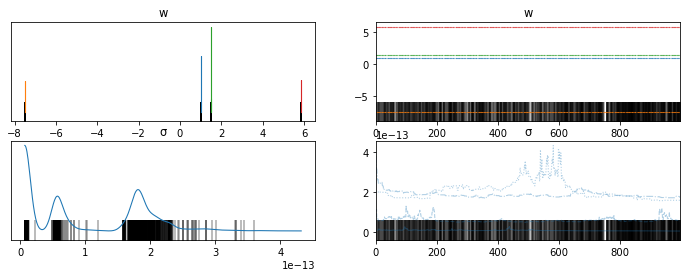

In [26]:
arviz.plot_trace(linear_model.trace_, combined=True)

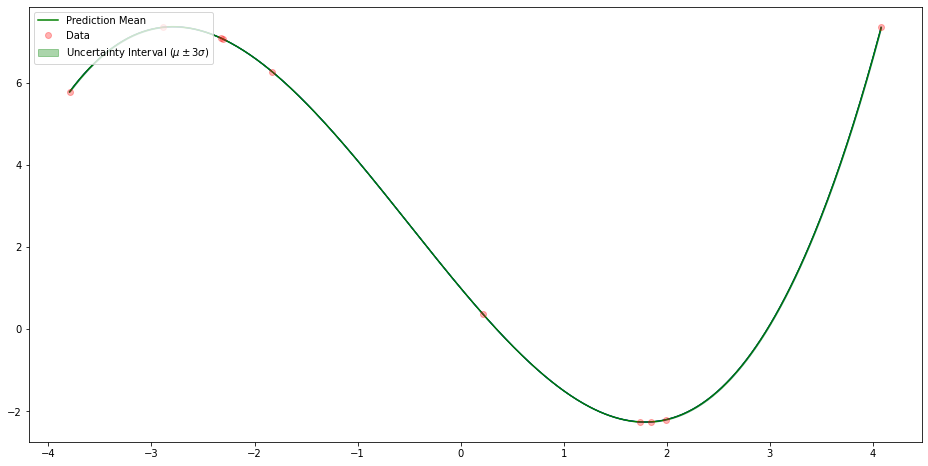

In [27]:
linear_model.plot(x,y)

# Bayesian Ridge Regression

**Ridge prior:**

$$
p(\mathbf{w} | \alpha) \sim \mathcal{N}(0, \alpha^{-1} \mathbf{I})
$$

$$
-\log p(\mathbf{w}  | \alpha) = \frac{\alpha }{2} \sum_j w_j^2 + const
$$


**Overfitted example:**


Cannot sample prior
Cannot sample from Flat distribution


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [w]


Sampling 4 chains for 2_000 tune and 20_000 draw iterations (8_000 + 80_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


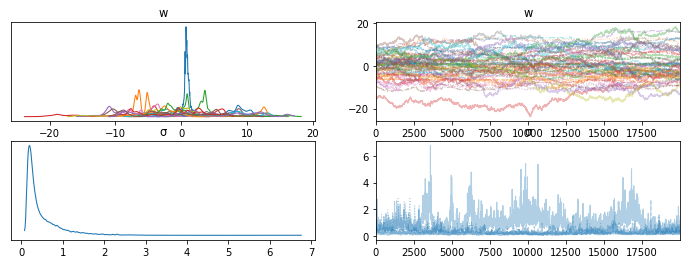

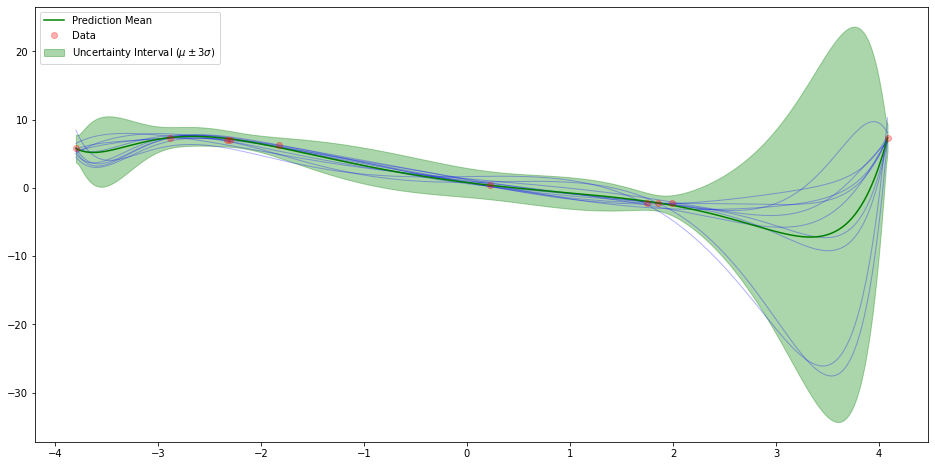

In [34]:
#An overfitted example

#Define linear model:
model15, transform15 = linear_regression(x, y, degree=15)
pymc3_model_15d = PyMC3Model(model15, transform=transform15)
#inference
pymc3_model_15d.fit(x,y,n_samples=20000,tune=2000, step_str='Metropolis')


arviz.plot_trace(pymc3_model_15d.trace_, combined=True)

pymc3_model_15d.plot(x,y)

Text(0.5, 1.0, 'Overfitted')

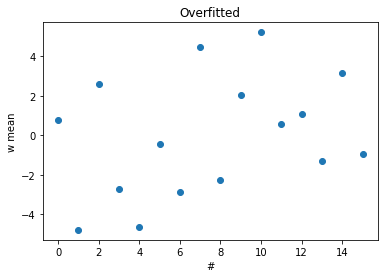

In [35]:
w = pymc3_model_15d.trace_['w']
w = w.mean(axis=0)

plt.scatter(np.arange(w.size), w.flatten());
plt.xlabel('#')
plt.ylabel('w mean')
plt.title('Overfitted')

Discuss with group:
    1. Inspect the trace - what can you see? diverges, random walk
    2. What can you observe about the weights? High absolute value
    3. What can you observe about the function predictions? Ill-conditioned probelm, goes haywire away from data

**Same example with Bayesian ridge:**


In [51]:
def ridge_regression(x, y, degree=10):
    
    transform, scale = gen_polynomial(x, degree=degree)
    x_p = transform(x)

    with pm.Model() as model:
        w = pm.Normal('w', mu=0, sigma=2, shape=x_p.shape[1])
        σ = pm.HalfCauchy('σ', beta=20.)
        x_ = pm.Data('features', x_p)
        y_ = pm.Data('observed', y.squeeze())
        y_obs = pm.Normal('y', mu=tt.dot(x_, w), sd=σ, observed=y_)

    return model, transform


In [52]:
ridge15, r_transform15 = ridge_regression(x, y, degree=15)
pymc3_model_ridge_15d = PyMC3Model(ridge15, transform=r_transform15)


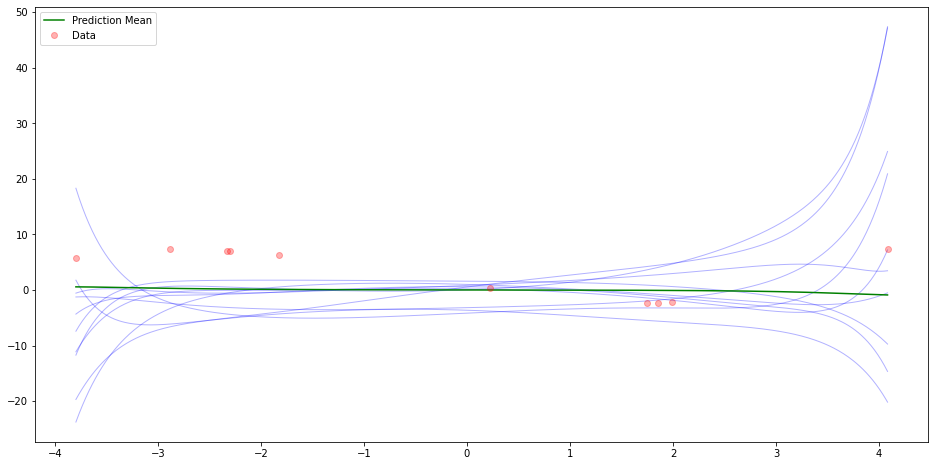

In [53]:
#Inspecting priors: Does the prior have the the needed capacity?
pymc3_model_ridge_15d.plot(x,y, plot_prior=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [w]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


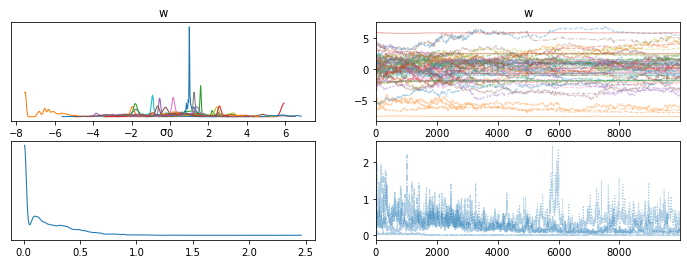

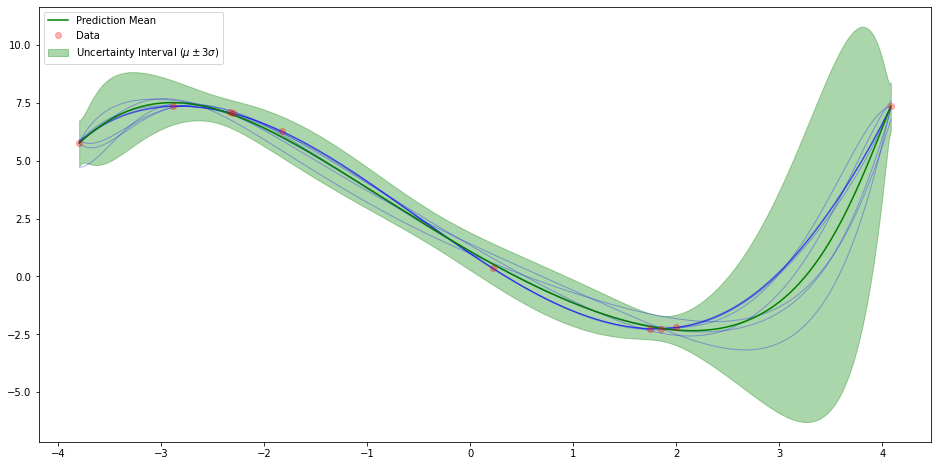

In [54]:
#inference
pymc3_model_ridge_15d.fit(x,y,n_samples=10000, tune=5000, step_str='Metropolis' )


arviz.plot_trace(pymc3_model_ridge_15d.trace_, combined=True);

pymc3_model_ridge_15d.plot(x,y)

Text(0.5, 1.0, 'Ridge')

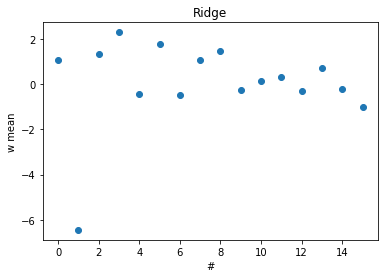

In [55]:
w = pymc3_model_ridge_15d.trace_['w']
w = w.mean(axis=0)

plt.scatter(np.arange(w.size), w.flatten());
plt.xlabel('#')
plt.ylabel('w mean')
plt.title('Ridge')

# Bayesian LASSO Regression

**LASSO: least absolute shrinkage and selection operator**

$$
p(\mathbf{w} | \beta) \sim \exp(-\beta |\mathbf{w}|)
$$

$$
-\log p(\mathbf{w}  | \beta) ={\beta }\sum_j |w_j| + const
$$


In [63]:
def lasso_regression(x, y, degree=10):
    
    transform, scale = gen_polynomial(x, degree=degree)
    x_p = transform(x)

    with pm.Model() as model:
        w = pm.Laplace('w', mu=0, b=1, shape=x_p.shape[1])
        σ = pm.HalfCauchy('σ', beta=20.)
        x_ = pm.Data('features', x_p)
        y_ = pm.Data('observed', y.squeeze())
        y_obs = pm.Normal('y', mu=tt.dot(x_, w), sd=σ, observed=y_)

    return model, transform



In [64]:
lasso15, l_transform15 = lasso_regression(x, y, degree=15)
pymc3_model_lasso_15d = PyMC3Model(lasso15, transform=l_transform15)


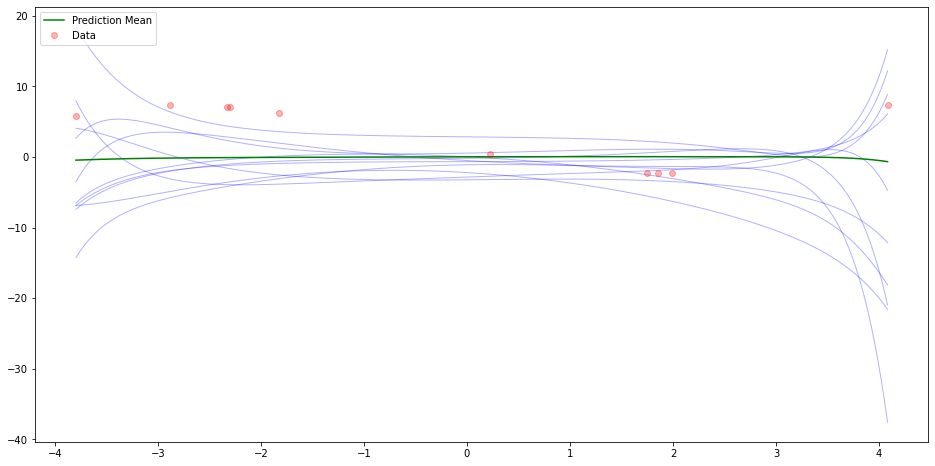

In [65]:
#plot prior
pymc3_model_lasso_15d.plot(x,y, plot_prior=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [σ]
>Metropolis: [w]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


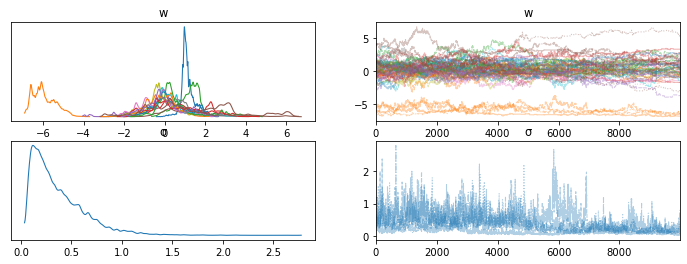

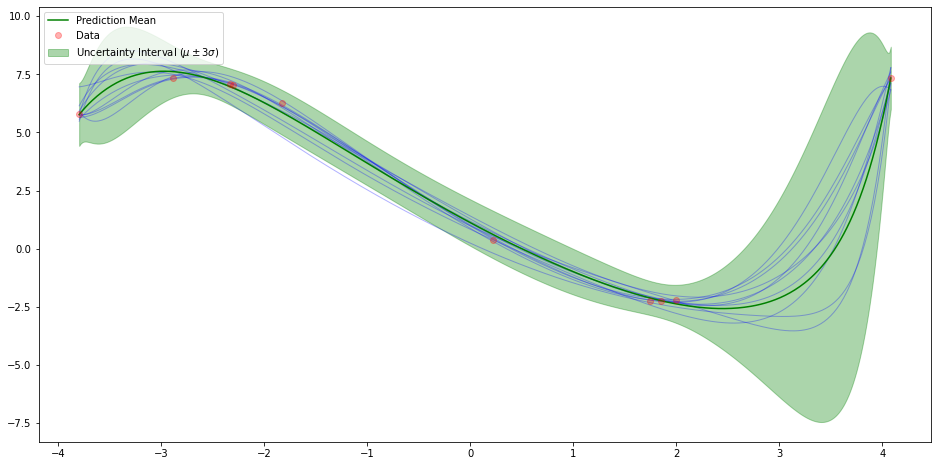

In [66]:
#inference
pymc3_model_lasso_15d.fit(x,y,n_samples=10000, tune=5000, step_str='Metropolis')


arviz.plot_trace(pymc3_model_lasso_15d.trace_, combined=True);

pymc3_model_lasso_15d.plot(x,y)

Text(0.5, 1.0, 'LASSO')

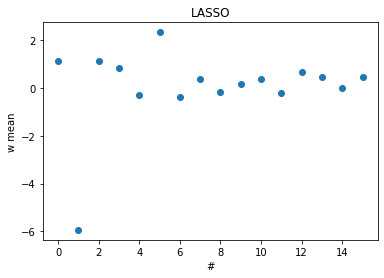

In [67]:
w = pymc3_model_lasso_15d.trace_['w']
w = w.mean(axis=0)

plt.scatter(np.arange(w.size), w.flatten());
plt.xlabel('#')
plt.ylabel('w mean')
plt.title('LASSO')

**Horseshoe prior**

Horseshoe offers both a local and global control of variable that enable to put mass at zero and support a long tail.

$$
\tau \sim \text{Cauchy}^+(0,1)
$$

$$
\lambda_i \sim \text{Cauchy}^+(0,1)
$$

$$
\mathbf{w} \sim \mathcal{N}(0, \tau^2\lambda^2_i)
$$

In [68]:
def horseshoe_regression(x, y, degree=10):
    transform, scale = gen_polynomial(x, degree=degree)
    x_p = transform(x)

    with pm.Model() as model:

        τ = pm.HalfCauchy('tau', beta=1)
        λ = pm.HalfCauchy('lambda', beta=1)
        w = pm.Normal('w', mu=0, sigma=τ*λ, shape=x_p.shape[1])
        σ = pm.HalfCauchy('σ', beta=20.)
        x_ = pm.Data('features', x_p)
        y_ = pm.Data('observed', y.squeeze())
        y_obs = pm.Normal('y', mu=tt.dot(x_, w), sd=σ, observed=y_)

    return model, transform


In [69]:
hs15, hs_transform15 = horseshoe_regression(x, y, degree=15)
pymc3_model_hs_15d = PyMC3Model(hs15, transform=hs_transform15)

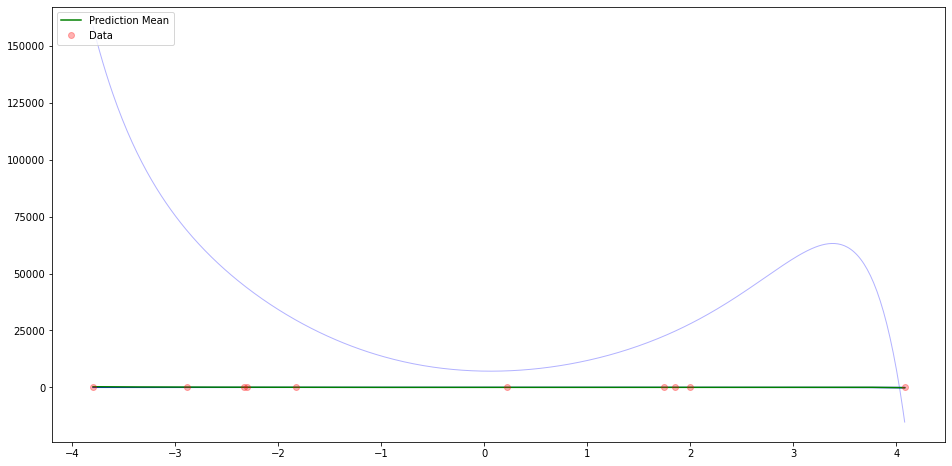

In [70]:
#Plot Prior - Does the prior have the the needed capacity?
pymc3_model_hs_15d.plot(x,y, plot_prior=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w, lambda, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
There were 422 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7203933554126234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
There were 400 divergences after tuning. Increase `target_accept` or reparameterize.
There were 403 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


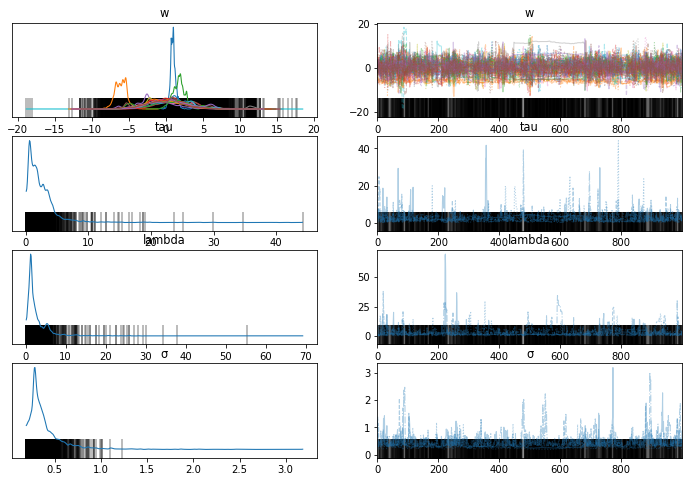

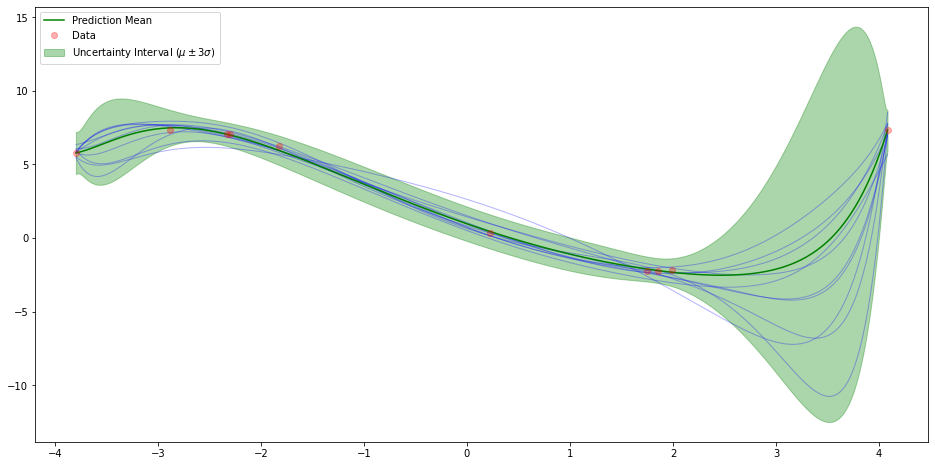

In [71]:
#inference
pymc3_model_hs_15d.fit(x,y,n_samples=1000, tune=1000, step_str='NUTS')


arviz.plot_trace(pymc3_model_hs_15d.trace_, combined=True);

pymc3_model_hs_15d.plot(x,y)

Text(0.5, 1.0, 'Horseshoe')

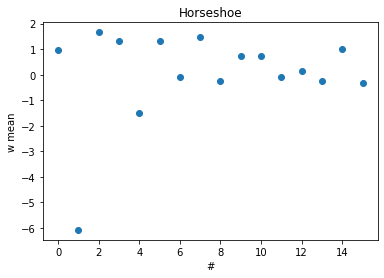

In [73]:
w = pymc3_model_hs_15d.trace_['w']
w = w.mean(axis=0)

plt.scatter(np.arange(w.size), w.flatten());
plt.xlabel('#')
plt.ylabel('w mean')
plt.title('Horseshoe')